In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [3]:
DATA_DIR = "/Users/adam/OneDrive - University of Massachusetts/ValleyBike/*.csv"
DATA_FILES = glob.glob(DATA_DIR)

In [5]:
dfs = []
for f in DATA_FILES:
    dfs.append(pd.read_csv(f))

/var/folders/0k/kp1z5hs92qs430gh81z0m3g00000gn/T/ipykernel_77183/2740497307.py:3: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f))
/var/folders/0k/kp1z5hs92qs430gh81z0m3g00000gn/T/ipykernel_77183/2740497307.py:3: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f))
/var/folders/0k/kp1z5hs92qs430gh81z0m3g00000gn/T/ipykernel_77183/2740497307.py:3: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f))
/var/folders/0k/kp1z5hs92qs430gh81z0m3g00000gn/T/ipykernel_77183/2740497307.py:3: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f))
/var/folders/0k/kp1z5hs92qs430gh81z0m3g00000gn/T/ipykernel_77183/2740497307.py:3: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option

In [6]:
df = pd.concat(dfs)

In [7]:
df["Date"] = pd.to_datetime(df["Date"])

In [8]:
df.sort_values(by='Date')
print(df)

                                                Route ID    Bike  \
0      route_05_2021@85102858-c13c-4d82-8bd8-60570700...  3454.0   
1      route_05_2021@85102858-c13c-4d82-8bd8-60570700...  3454.0   
2      route_05_2021@85102858-c13c-4d82-8bd8-60570700...  3454.0   
3      route_05_2021@85102858-c13c-4d82-8bd8-60570700...  3454.0   
4      route_05_2021@85102858-c13c-4d82-8bd8-60570700...  3454.0   
...                                                  ...     ...   
14968  route_05_2021@4c3ae583-51bd-45e3-a031-e6549b9e...   985.0   
14969  route_05_2021@4c3ae583-51bd-45e3-a031-e6549b9e...   985.0   
14970  route_05_2021@4c3ae583-51bd-45e3-a031-e6549b9e...   985.0   
14971  route_05_2021@4c3ae583-51bd-45e3-a031-e6549b9e...   985.0   
14972  route_05_2021@4c3ae583-51bd-45e3-a031-e6549b9e...   985.0   

                           Date   Latitude  Longitude Routes & locations  \
0     2021-05-29 10:10:34+00:00  42.204525  -72.60295                NaN   
1     2021-05-29 10:10:39+00:00

In [8]:
routesDict = {}
for index, row in df.iterrows():
    ID = row['Route ID']
    time = row['Date']
    location = (row['Latitude'], row['Longitude'])
    if ID not in routesDict.keys():
        routesDict[ID] = {"locations": [location], "startTime": time, "endTime": time}
    else:
        routesDict[ID]["locations"].append(location)
        routesDict[ID]["endTime"] = time


In [13]:
print(list(routesDict.keys())[11])

route_05_2021@2024df13-5283-4c26-a09a-b427774360e0


-72.56012833333334 42.35380166666667 -72.533285 42.36834
route_05_2021@2024df13-5283-4c26-a09a-b427774360e0: start time: 2021-05-29 15:33:09+00:00, end time: 2021-05-29 16:56:39+00:00


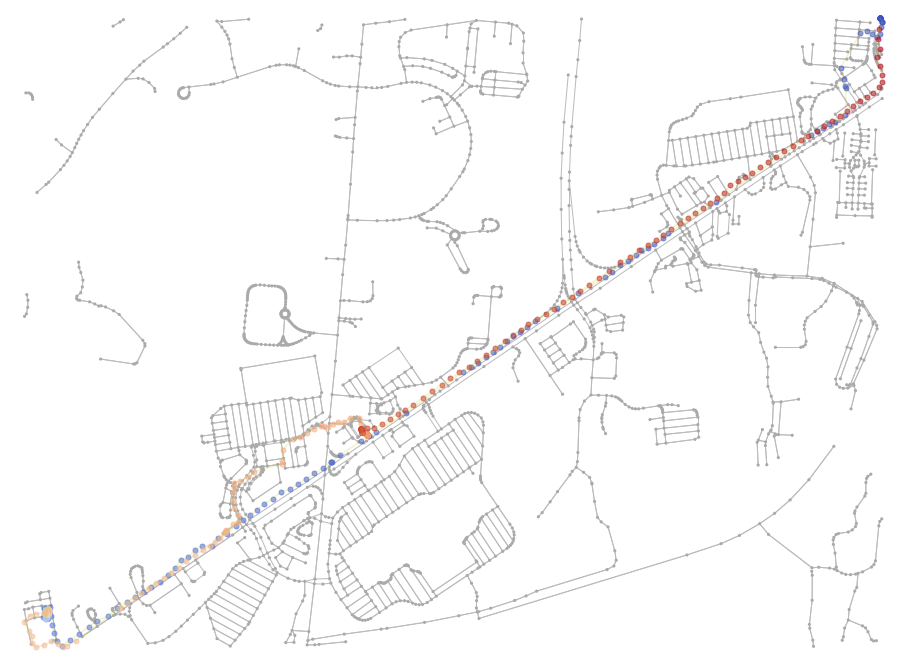

In [50]:
import pandas as pd
import numpy as np
import sys
import math
import osmnx as ox
import networkx as nx
import pickle
from time import time
import time
from xml.dom import NotFoundErr
import itertools
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import osmnx.geometries as gx
import numpy as np
import math

route = routesDict["route_05_2021@2024df13-5283-4c26-a09a-b427774360e0"]
locationList = route["locations"]
startTime = route["startTime"]
endTime = route["endTime"]

pointsList = []
for lat, long in locationList:
    pointsList.append(Point(long, lat))

# convert to GeoDataFrame (enables next step)
points = gpd.GeoSeries(pointsList, crs='epsg:4326')
gpd = gpd.GeoDataFrame({'geometry': pointsList})

minx, miny, maxx, maxy = gpd.geometry.total_bounds
print(minx, miny, maxx, maxy)
print("route_05_2021@2024df13-5283-4c26-a09a-b427774360e0: start time: {}, end time: {}".format(startTime, endTime))
if (minx == maxx) and (miny == maxy):
    print("invalid route!")
else:
    G = ox.graph_from_bbox(miny, maxy, minx, maxx, simplify=False, retain_all=True)

    # project to CRS (coordinate reference system) used by the projected graph (this is for accuracy)
    pointsProg = points.to_crs(G.graph['crs'])

fig, ax = ox.plot_graph(
    G, bgcolor="w", node_color="#AAAAAA", figsize=(20, 12), node_size=10, edge_linewidth=1, edge_color="#BBBBBB", show=False, save=False, close=False
)

cmap = plt.cm.get_cmap('coolwarm',len(pointsProg))
colors = list(cmap(np.arange(len(pointsProg))))
colors[0] = "#000000"
pointsX = []
pointsY = []
for i, point in enumerate(pointsProg):
    pointsX.append(point.x)
    pointsY.append(point.y)
    ax.scatter(point.x, point.y, color=colors[i], s = 25, alpha = 0.6)
ax.plot(pointsX, pointsY, c="y", alpha = 0.2)

extent = ax.bbox.transformed(fig.dpi_scale_trans.inverted())
plt.draw()
plt.show()

In [9]:
routesDict = {}
startLocations = set()

for index, row in df.iterrows():
    ID = row['Route ID']
    time = row['Date']
    location = (row['Latitude'], row['Longitude'])
    if ID not in routesDict.keys():
        routesDict[ID] = {"locations": [location], "startTime": time, "endTime": time}
        startLocations.add(location)
    else:
        routesDict[ID]["locations"].append(location)
        routesDict[ID]["endTime"] = time

In [38]:
stations = pd.read_csv("stations.csv")
lats = list(stations.get('latitude'))
longs = list(stations.get('longitude'))

stationDict = {}
for index, row in stations.iterrows():
    ID = row['name']
    lat = lats[index]
    long = longs[index]
    stationDict[ID] = (lat, long)

NaT NaT
0.0 0.0
nan nan
-72.75211 42.085245 -72.486055 42.41256833333333


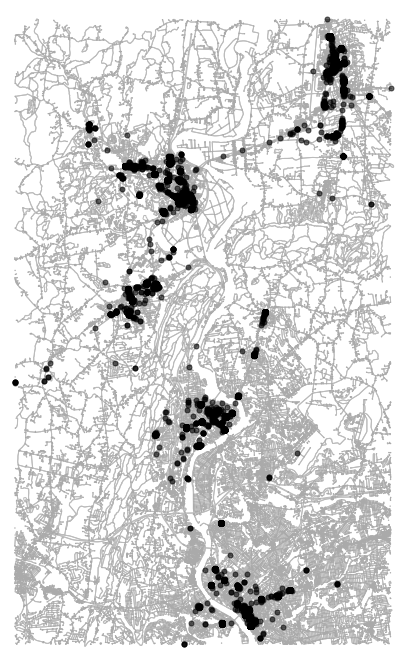

In [18]:
import pandas as pd
import numpy as np
import sys
import math
import osmnx as ox
import networkx as nx
import pickle
from time import time
import time
from xml.dom import NotFoundErr
import itertools
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import osmnx.geometries as gx
import numpy as np
import math

pointsList = []
for lat, long in list(startLocations):
    try:
        if lat > 40 and long < -65:
            pointsList.append(Point(long, lat))
        else:
            print(long, lat)
    except:
        print(long, lat)

# convert to GeoDataFrame (enables next step)
points = gpd.GeoSeries(pointsList, crs='epsg:4326')
gpd = gpd.GeoDataFrame({'geometry': pointsList})

minx, miny, maxx, maxy = gpd.geometry.total_bounds
print(minx, miny, maxx, maxy)
G = ox.graph_from_bbox(miny, maxy, minx, maxx, simplify=True, retain_all=True)

# project to CRS (coordinate reference system) used by the projected graph (this is for accuracy)
pointsProg = points.to_crs(G.graph['crs'])

fig, ax = ox.plot_graph(
    G, bgcolor="w", node_color="#AAAAAA", figsize=(20, 12), node_size=2, edge_linewidth=1, edge_color="#BBBBBB", show=False, save=False, close=False
)

pointsX = []
pointsY = []
for i, point in enumerate(pointsProg):
    pointsX.append(point.x)
    pointsY.append(point.y)
    ax.scatter(point.x, point.y, color="#000000", s = 25, alpha = 0.6)

extent = ax.bbox.transformed(fig.dpi_scale_trans.inverted())
plt.draw()
plt.show()